# Structure from Motion (SfM)

1. [Extract video frames](#extract-video-frames)
2. [Feature Detection + Extraction: SIFT](#feature-detection--extraction-sift)
3. [Feature matching: BFMatcher - knnMatch](#feature-matching-bfmatcher---knnmatch)
4. [Mask](#mask)
5. [Motion Estimation](#motion-estimation)

## Extract video frames

In [1]:
import os
import cv2

In [2]:
def save_video_frames(
    video_path: str,
    output_folder: str,
    start_frame: int = 0,
    end_frame: int | None = None,
    interval: int = 10,
) -> None:
    os.makedirs(output_folder, exist_ok=True)

    vidcap = cv2.VideoCapture(video_path)
    success, image = vidcap.read()

    if end_frame is None:
        end_frame = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    count = start_frame

    while success and count <= end_frame:
        if count % interval == 0:
            cv2.imwrite(os.path.join(output_folder, f"frame_{count}.jpg"), image)
        success, image = vidcap.read()
        count += 1

    vidcap.release()
    cv2.destroyAllWindows()

In [3]:
import os
import cv2

def save_video_frames_2(
    video_path: str,
    output_folder: str,
    start_time: float = 0.0,     # time in seconds
    end_time: float | None = None,  # time in seconds
    interval: int = 10           # frame interval
) -> None:
    os.makedirs(output_folder, exist_ok=True)

    vidcap = cv2.VideoCapture(video_path)
    fps = vidcap.get(cv2.CAP_PROP_FPS)
    total_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))

    start_frame = int(start_time * fps)
    end_frame = int(end_time * fps) if end_time is not None else total_frames

    vidcap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
    count = start_frame

    success, image = vidcap.read()

    while success and count <= end_frame:
        if count % interval == 0:
            filename = os.path.join(output_folder, f"frame_{count}.jpg")
            cv2.imwrite(filename, image)
        success, image = vidcap.read()
        count += 1

    vidcap.release()
    cv2.destroyAllWindows()


In [4]:
save_video_frames(video_path='data/10SOM282.mp4', output_folder='data/video_2/frames', start_frame=0, end_frame=2000, interval=10)

In [8]:
save_video_frames_2(
    video_path="data/10SOM282.mp4",
    output_folder="video_2/frames",
    start_time=5 * 60 + 55,
    end_time=6 * 60 + 27,
    interval=2
)

## Feature Detection + Extraction: SIFT

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from typing import Sequence
from cv2 import DMatch, KeyPoint

In [5]:
def extract_features_sift(image: np.ndarray, mask: np.ndarray | None = None) -> tuple[Sequence[KeyPoint], np.ndarray]:
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, mask)
    print(f"Number of keypoints: {len(keypoints)}")
    print(f"Descriptors shape: {descriptors.shape}")
    return keypoints, descriptors

In [6]:
def visualize_features(image: np.ndarray, keypoints: list, output_path: str) -> None:
    if not os.path.exists(os.path.dirname(output_path)):
        os.makedirs(os.path.dirname(output_path))
        
    image_with_keypoints = cv2.drawKeypoints(image, keypoints, None)
    cv2.imwrite(output_path, image_with_keypoints)

In [7]:
import pickle
with open('data/mask.pkl', 'rb') as f:
    mask = pickle.load(f)

In [8]:
frame_8700 = cv2.imread("data/frames/frame_8700.jpg", cv2.IMREAD_GRAYSCALE)
frame_8710 = cv2.imread("data/frames/frame_8710.jpg", cv2.IMREAD_GRAYSCALE)

keypoints_frame_8700, descriptors_frame_8700 = extract_features_sift(image=frame_8700, mask=mask)
visualize_features(
    image=frame_8700,
    keypoints=keypoints_frame_8700,
    output_path="data/frame_keypoints/frame_8700.jpg",
)

keypoints_frame_8710, descriptors_frame_8710 = extract_features_sift(image=frame_8710, mask=mask)
visualize_features(
    image=frame_8710,
    keypoints=keypoints_frame_8710,
    output_path="data/frame_keypoints/frame_8710.jpg",
)

Number of keypoints: 695
Descriptors shape: (695, 128)
Number of keypoints: 783
Descriptors shape: (783, 128)


## Feature matching: BFMatcher - knnMatch

In [9]:
def match_features(
    descriptors_frame_1: np.ndarray, descriptors_frame_2: np.ndarray, k: int = 2
) -> list[DMatch]:
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(descriptors_frame_1, descriptors_frame_2, k=k)

    print(f"Number of matches: {len(matches)}")
    print(f"Matches shape: {np.array(matches).shape}")
    
    # Lowe's ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    return good_matches


In [10]:
def estimate_motion_and_triangulate(kp1, kp2, des1, des2, K):
    # Match features
    matches = match_features(des1, des2)
    pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])

    # Essential matrix and pose
    E, mask = cv2.findEssentialMat(pts1, pts2, K, method=cv2.RANSAC, threshold=1.0)
    _, R, t, _ = cv2.recoverPose(E, pts1, pts2, K)

    # Projection matrices
    P0 = K @ np.hstack((np.eye(3), np.zeros((3, 1))))
    P1 = K @ np.hstack((R, t))

    # Triangulate
    pts4d = cv2.triangulatePoints(P0, P1, pts1.T, pts2.T)
    points_3d = (pts4d[:3] / pts4d[3]).T

    return R, t, points_3d, matches

In [11]:
def visualize_matches(
    frame_1: np.ndarray,
    frame_2: np.ndarray,
    keypoints_frame_1: Sequence[KeyPoint],
    keypoints_frame_2: Sequence[KeyPoint],
    matches: list[DMatch],
    output_path: str,
) -> None:    
    img_matches = cv2.drawMatches(frame_1, keypoints_frame_1, frame_2, keypoints_frame_2, matches, None)
    img_matches_rgb = cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB)

    plt.imsave(output_path, img_matches_rgb)

    plt.figure(dpi=300)
    plt.imshow(img_matches_rgb)
    plt.axis("off")
    plt.show()

In [12]:
print(type(descriptors_frame_8700))

<class 'numpy.ndarray'>


In [13]:
feature_matches = match_features(descriptors_frame_8700, descriptors_frame_8710)

Number of matches: 695
Matches shape: (695, 2)


Number of matches: 695
Matches shape: (695, 2)


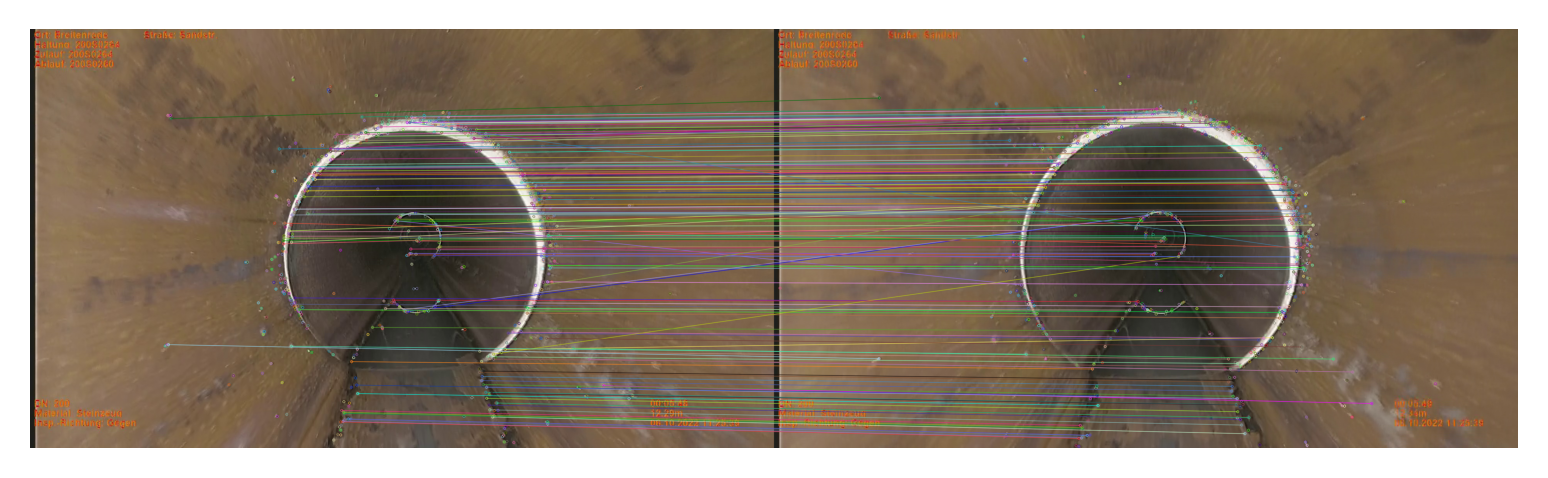

In [14]:
feature_matches_list = match_features(
    descriptors_frame_8700, descriptors_frame_8710, k=2
)

visualize_matches(
    cv2.imread("data/frames/frame_8700.jpg"),
    cv2.imread("data/frames/frame_8710.jpg"),
    keypoints_frame_8700,
    keypoints_frame_8710,
    matches=sorted(feature_matches, key=lambda x: x.distance),
    output_path=f"data/frame_matches/frames_8700_8710_best_matches.jpg",
    )

Number of matches: 695
Matches shape: (695, 2)


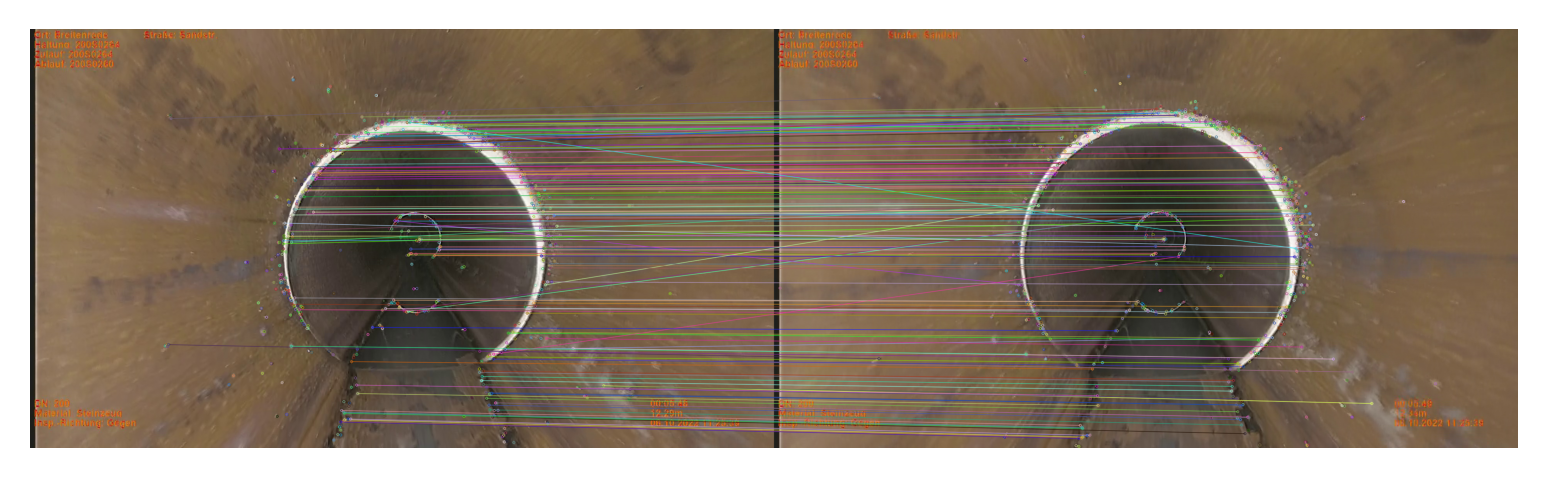

In [15]:
feature_matches = match_features(descriptors_frame_8700, descriptors_frame_8710)

visualize_matches(
    cv2.imread("data/frames/frame_8700.jpg"),
    cv2.imread("data/frames/frame_8710.jpg"),
    keypoints_frame_8700,
    keypoints_frame_8710,
    matches=sorted(feature_matches, key=lambda x: x.distance),
    output_path="data/frame_matches/frames_8700_8710_all_matches_unmasked.jpg",
)

In [16]:
feature_matches

[<DMatch 000002574D5CCA30>,
 <DMatch 000002574D5CCB50>,
 <DMatch 000002574D5CD590>,
 <DMatch 000002574D5CD9B0>,
 <DMatch 000002574D5CDA70>,
 <DMatch 000002574D5CDB30>,
 <DMatch 000002574D5CDCD0>,
 <DMatch 000002574D5CDFD0>,
 <DMatch 000002574D5CE090>,
 <DMatch 000002574D5CE3B0>,
 <DMatch 000002574D5CE5B0>,
 <DMatch 000002574D5CE5F0>,
 <DMatch 000002574D5CE690>,
 <DMatch 000002574D5CE6D0>,
 <DMatch 000002574D5CE950>,
 <DMatch 000002574D5CEAD0>,
 <DMatch 000002574D5CECD0>,
 <DMatch 000002574D5CEDF0>,
 <DMatch 000002574D5CEF10>,
 <DMatch 000002574D5CF0D0>,
 <DMatch 000002574D5CF5B0>,
 <DMatch 000002574D5CF6D0>,
 <DMatch 000002574D5CF790>,
 <DMatch 000002574D5CF8B0>,
 <DMatch 000002574D5CF990>,
 <DMatch 000002574D5CFAD0>,
 <DMatch 000002574D5CFCD0>,
 <DMatch 000002574D5CFD70>,
 <DMatch 000002574D5CFEF0>,
 <DMatch 000002574D5CFF30>,
 <DMatch 000002574D5CFF90>,
 <DMatch 000002574D5CFFD0>,
 <DMatch 000002574D6040B0>,
 <DMatch 000002574D604110>,
 <DMatch 000002574D604150>,
 <DMatch 000002574D6

## Mask

In [ ]:
import cv2
import numpy as np

image = cv2.imread('processed_selected_frames_2\\frame_5700.jpg')
clone = image.copy()

mask = np.ones(image.shape[:2], dtype=np.uint8) * 255
rois = cv2.selectROIs("Select multiple regions (ENTER to confirm, ESC to cancel)", clone, fromCenter=False)

for r in rois:
    x, y, w, h = r
    mask[y:y+h, x:x+w] = 0
    cv2.rectangle(clone, (x, y), (x+w, y+h), (0, 0, 255), 2)

cv2.imshow("Final Mask", mask)
cv2.imshow("Image with Selections", clone)
cv2.waitKey(0)
cv2.destroyAllWindows()

cv2.imwrite('mask_video_4.png', mask)

True

In [3]:
for i in range(0, 341):
    number = str(i).zfill(4)
    cv2.imwrite(f"masks/frame_{number}.png.png", mask)

In [199]:
print(mask)

[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


In [8]:
import pickle

with open("data/mask.pkl", "wb") as f:
    pickle.dump(mask, f)

In [ ]:
keypoints, descriptors = extract_features_sift(
    image=frame_8700,
    mask=None,
)

In [186]:
keypoints

(< cv2.KeyPoint 00000254264776F0>,
 < cv2.KeyPoint 0000025426474660>,
 < cv2.KeyPoint 000002542616C960>,
 < cv2.KeyPoint 0000025426356940>,
 < cv2.KeyPoint 0000025426356C40>,
 < cv2.KeyPoint 0000025426360AB0>,
 < cv2.KeyPoint 000002542635D4A0>,
 < cv2.KeyPoint 000002542635FD80>,
 < cv2.KeyPoint 000002542635F0C0>,
 < cv2.KeyPoint 000002542635F120>,
 < cv2.KeyPoint 000002542635C7B0>,
 < cv2.KeyPoint 0000025426350D20>,
 < cv2.KeyPoint 0000025426351020>,
 < cv2.KeyPoint 0000025426353270>,
 < cv2.KeyPoint 00000254263521C0>,
 < cv2.KeyPoint 0000025426350270>,
 < cv2.KeyPoint 00000254263524F0>,
 < cv2.KeyPoint 00000254263537E0>,
 < cv2.KeyPoint 00000254263539C0>,
 < cv2.KeyPoint 0000025426350CF0>,
 < cv2.KeyPoint 00000254263510E0>,
 < cv2.KeyPoint 0000025426353F60>,
 < cv2.KeyPoint 0000025426353960>,
 < cv2.KeyPoint 0000025426352B80>,
 < cv2.KeyPoint 0000025426350B10>,
 < cv2.KeyPoint 00000254263523D0>,
 < cv2.KeyPoint 0000025426351D40>,
 < cv2.KeyPoint 0000025426350750>,
 < cv2.KeyPoint 0000

In [ ]:
visualize_features(
    image=frame_8700,
    keypoints=keypoints,
    output_path="data/frame_keypoints/frame_8700_masked.jpg",
)

## Motion Estimation

In [18]:
image_dir = "data/frames"
image_paths = sorted([
    os.path.join(image_dir, f)
    for f in os.listdir(image_dir)
    if f.lower().endswith(".jpg")
])
images = [cv2.imread(p, cv2.IMREAD_GRAYSCALE) for p in image_paths][0:100]

In [9]:
with open("data/mask.pkl", "rb") as f:
    mask = pickle.load(f)

In [27]:
keypoints_list = []
descriptors_list = []

for image in images:
    keypoints, descriptors = extract_features_sift(image, mask=mask)
    keypoints_list.append(keypoints)
    descriptors_list.append(descriptors)


Number of keypoints: 12372
Descriptors shape: (12372, 128)
Number of keypoints: 14394
Descriptors shape: (14394, 128)
Number of keypoints: 16866
Descriptors shape: (16866, 128)
Number of keypoints: 16487
Descriptors shape: (16487, 128)
Number of keypoints: 16147
Descriptors shape: (16147, 128)
Number of keypoints: 16402
Descriptors shape: (16402, 128)
Number of keypoints: 16397
Descriptors shape: (16397, 128)
Number of keypoints: 16144
Descriptors shape: (16144, 128)
Number of keypoints: 15446
Descriptors shape: (15446, 128)
Number of keypoints: 15546
Descriptors shape: (15546, 128)
Number of keypoints: 15653
Descriptors shape: (15653, 128)
Number of keypoints: 15227
Descriptors shape: (15227, 128)
Number of keypoints: 15918
Descriptors shape: (15918, 128)
Number of keypoints: 15606
Descriptors shape: (15606, 128)
Number of keypoints: 15011
Descriptors shape: (15011, 128)
Number of keypoints: 15792
Descriptors shape: (15792, 128)
Number of keypoints: 15036
Descriptors shape: (15036, 12

In [29]:
height, width = image.shape[:2]
focal_length_px = width  # or 0.5 * width

K = np.array([
    [focal_length_px, 0, width / 2],
    [0, focal_length_px, height / 2],
    [0, 0, 1]
])

In [32]:
print(K)

[[1.92e+03 0.00e+00 9.60e+02]
 [0.00e+00 1.92e+03 5.40e+02]
 [0.00e+00 0.00e+00 1.00e+00]]


In [ ]:
# Match features between frame 0 and frame 1
bf = cv2.BFMatcher()
matches = bf.knnMatch(descriptors_list[0], descriptors_list[1], k=2)

good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]

pts1 = np.float32([keypoints_list[0][m.queryIdx].pt for m in good_matches])
pts2 = np.float32([keypoints_list[1][m.trainIdx].pt for m in good_matches])

# Estimate essential matrix
E, mask = cv2.findEssentialMat(pts1, pts2, K, method=cv2.RANSAC, threshold=1.0)
_, R, t, mask_pose = cv2.recoverPose(E, pts1, pts2, K)

# Camera projection matrices
P0 = K @ np.hstack((np.eye(3), np.zeros((3, 1))))
P1 = K @ np.hstack((R, t))

# Triangulate initial points
pts4d_hom = cv2.triangulatePoints(P0, P1, pts1.T, pts2.T)
points_3d = (pts4d_hom[:3] / pts4d_hom[3]).T

# Store camera poses
camera_poses = [P0, P1]

In [ ]:
for i in range(2, len(images)):
    print(f"Processing frame {i}...")

    # Match features between the new frame and last registered frame
    matches = bf.knnMatch(descriptors_list[i-1], descriptors_list[i], k=2)
    good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]

    pts_prev = np.float32([keypoints_list[i-1][m.queryIdx].pt for m in good_matches])
    pts_curr = np.float32([keypoints_list[i][m.trainIdx].pt for m in good_matches])

    # Get corresponding 3D points (from previous triangulation)
    # Note: in practice you'd track 2D-3D correspondences via feature IDs
    object_points = []
    image_points = []

    for j, m in enumerate(good_matches):
        if mask_pose[j]:  # Reuse pose mask
            object_points.append(points_3d[j])
            image_points.append(pts_curr[j])

    object_points = np.array(object_points, dtype=np.float32)
    image_points = np.array(image_points, dtype=np.float32)

    # Solve PnP to get pose of new camera
    success, rvec, tvec, inliers = cv2.solvePnPRansac(object_points, image_points, K, None)
    R, _ = cv2.Rodrigues(rvec)
    t = tvec

    P_new = K @ np.hstack((R, t))
    camera_poses.append(P_new)

    # Triangulate new points between previous and current view
    new_pts1 = pts_prev[inliers[:, 0]]
    new_pts2 = pts_curr[inliers[:, 0]]
    P_prev = camera_poses[i-1]

    pts4d_new = cv2.triangulatePoints(P_prev, P_new, new_pts1.T, new_pts2.T)
    pts3d_new = (pts4d_new[:3] / pts4d_new[3]).T

    # Merge new 3D points
    points_3d = np.vstack((points_3d, pts3d_new))


In [ ]:
def save_ply(filename, points):
    with open(filename, "w") as f:
        f.write(f"ply\nformat ascii 1.0\nelement vertex {len(points)}\n")
        f.write("property float x\nproperty float y\nproperty float z\nend_header\n")
        for p in points:
            f.write(f"{p[0]} {p[1]} {p[2]}\n")

save_ply("output_points.ply", points_3d)

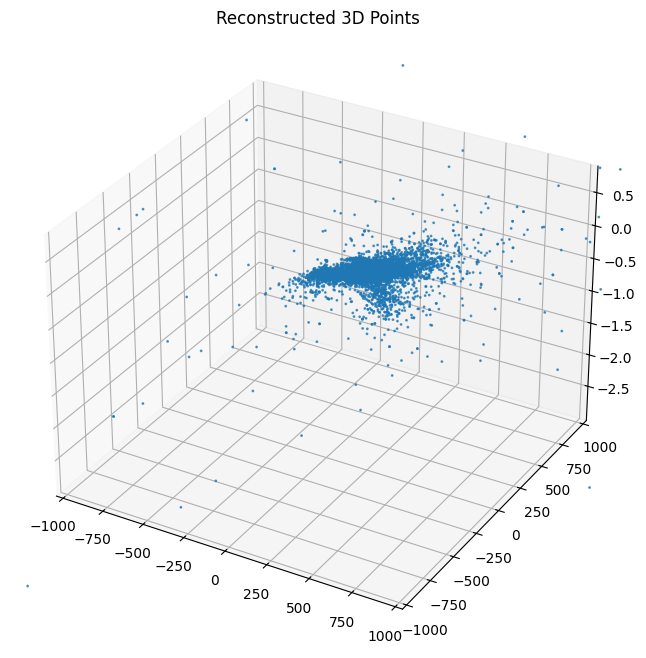

In [42]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2], s=1)
ax.set_title("Reconstructed 3D Points")
ax.set_xlim([-1000, 1000])
ax.set_ylim([-1000, 1000])

plt.show()


In [35]:
# Normalize the 3D points to a smaller range
scale_factor = np.max(np.abs(points_3d))
points_3d_normalized = points_3d / scale_factor


In [ ]:
matches_list = []
for i in range(len(images) - 1):
    matches = match_features(all_descriptors[i], all_descriptors[i + 1])
    matches_list.append(matches)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Assume you accumulate camera centers in a list `camera_centers`
for i, center in enumerate(camera_centers):
    ax.scatter(center[0], center[1], center[2], c='r', marker='o')
    ax.text(center[0], center[1], center[2], f"Cam{i}")

ax.set_title("Estimated Camera Poses")
plt.show()


In [ ]:
proj1 = K @ np.hstack((np.eye(3), np.zeros((3, 1))))
proj2 = K @ np.hstack((R, t))

points_4d = cv2.triangulatePoints(proj1, proj2, pts1.T, pts2.T)
points_3d = points_4d[:3] / points_4d[3]


## TEST

In [20]:
import cv2
import numpy as np
import os

def process_image(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    denoised = cv2.fastNlMeansDenoising(gray, h=10)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(denoised)
    gamma = 1.2
    lut = np.array([((i / 255.0) ** (1.0 / gamma)) * 255 for i in np.arange(256)]).astype("uint8")
    gamma_corrected = cv2.LUT(enhanced, lut)
    edges = cv2.Laplacian(gamma_corrected, cv2.CV_64F)
    edges = cv2.convertScaleAbs(edges)
    enhanced_edges = cv2.addWeighted(gamma_corrected, 0.8, edges, 0.2, 0)
    sharpening_kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    sharpened = cv2.filter2D(enhanced_edges, -1, sharpening_kernel)
    return sharpened

def process_directory(input_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    for filename in os.listdir(input_dir):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(input_dir, filename)
            img = cv2.imread(img_path)
            if img is not None:
                processed = process_image(img)
                out_path = os.path.join(output_dir, filename)
                cv2.imwrite(out_path, processed)
                print(f"Processed: {filename}")
            else:
                print(f"Failed to load: {filename}")

input_dir = 'frames_3'
output_dir = 'processed_frames_3'
process_directory(input_dir, output_dir)

Processed: frame_33470.jpg
Processed: frame_33475.jpg
Processed: frame_33480.jpg
Processed: frame_33485.jpg
Processed: frame_33490.jpg
Processed: frame_33495.jpg
Processed: frame_33500.jpg
Processed: frame_33505.jpg
Processed: frame_33510.jpg
Processed: frame_33515.jpg
Processed: frame_33520.jpg
Processed: frame_33525.jpg
Processed: frame_33530.jpg
Processed: frame_33535.jpg
Processed: frame_33540.jpg
Processed: frame_33545.jpg
Processed: frame_33550.jpg
Processed: frame_33555.jpg
Processed: frame_33560.jpg
Processed: frame_33565.jpg
Processed: frame_33570.jpg
Processed: frame_33575.jpg
Processed: frame_33580.jpg
Processed: frame_33585.jpg
Processed: frame_33590.jpg
Processed: frame_33595.jpg
Processed: frame_33600.jpg
Processed: frame_33605.jpg
Processed: frame_33610.jpg
Processed: frame_33615.jpg
Processed: frame_33620.jpg
Processed: frame_33625.jpg
Processed: frame_33630.jpg
Processed: frame_33635.jpg
Processed: frame_33640.jpg
Processed: frame_33645.jpg
Processed: frame_33650.jpg
P